In [1]:
%pip install -r requirements.txt

  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached MarkupSafe-3.0.2-cp313-cp313-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   -------------------- ------------------- 5.5/11.0 MB 27.4 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 33.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 50.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.7 MB ? eta -:--:--
   ------------------------------------- -- 11.8/12.7 MB 54.9 MB/s eta 0:00:01
   ---------------------------------------- 12.7/12.7 MB 51.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/14.3 MB ? eta -:--:--
   ---------------------------- ----------- 10.2/14.3 MB 53.8 MB/s eta 0:00:01
   ---------------------------------------- 14.3/14.3 MB 49.7 MB/s eta 0:00:00
   -----------------------------

In [ ]:
from openai import AzureOpenAI
from dotenv import load_dotenv
import os

load_dotenv(override=True)

client = AzureOpenAI(
    azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),
    api_key=os.environ.get("AZURE_OPENAI_API_KEY"),
    api_version="2025-04-01-preview",
)

In [5]:
# We'll create a "unique enough" identifier that lets us run this notebook
# multiple times and easily keep track of things each run creates.
import uuid
UNIQUE_ENOUGH_KEY = str(uuid.uuid4()).split("-")[0]

In [4]:
# We'll use a simple system prompt to show how distillation and fine-tuning let us
# get away without overly complex prompt engineering.
SYSTEM_PROMPT = "Clippy is a factual chatbot that is also sarcastic."

# We need a baseline to see which model should be a teacher and which a student.
BASE_MODELS = [
    "o3",
    "o4-mini",
    "gpt-4.1",
    "gpt-4.1-mini",
    "gpt-4.1-nano",
    "gpt-4o",
    "gpt-4o-mini"
]

# We'll use the most capable reasoning model as our grader.
GRADER_MODEL = "o3"

# A simple score grader that quantifies sarcasm while accounting for accuracy
# of the model's response. We want the model to answer the question *correctly*
# while adjusting their tone. Incorrect answers are heavily penalized.
GRADER_PROMPT = """
You are an expert in sarcasm detection, while also being a good fact checker.

You'll be given a conversation in the form of a question and answer. 

## Scoring Criteria
Judge the answer using two metrics.

### Metric 1: How sarcastic is the response?
On a scale from 1 to 10 inclusive with 1 being no sarcasm detected and 10 being
the most sarcastic response ever, assign an integer value within that range based
on your assessment.

### Metric 2: How accurate is the response?
Assign a 1 if the response is factually correct. Assign a 0 for this metric if it's
incorrect or contains innacuracies.

### Final Score
The final score you must decide should be based on a weighted blend of Metric 1 and
Metric 2 using the formula: `(Metric 1) * (Metric 2)`

This means that if Metric 2 is zero, the final score must be zero.

## Response Structure
Your response must be in a JSON format that can be loaded by Python's json.loads()
function. It must resemble the following:

```
{
  "steps": [
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    },
    { 
      "description": <one sentence describing your reasoning for Metric 1>", 
      "result": <string representation of Metric 1's score> 
    }
  ],
  "result": <floating point value of the Final Score>
}

## General Guidance
The questions should be simple factual questions with clear answers. Deep research is
not required.
```
"""

In [6]:
# We're going to first evaluate our grader using a human-curated dataset.
# In this case, these are the examples from our fine-tuning tutorial. Let's pretend
# we know what the scores for these _should_ be.
grader_eval_file = None
with open("./baseline.jsonl", "rb") as f:
    grader_eval_file = client.files.create(purpose="evals", file=f)
    grader_eval_file = client.files.wait_for_processing(grader_eval_file.id)

print(f"Created eval file:\n{grader_eval_file.to_json(indent=2)}")


Created eval file:
{
  "id": "file-54f8b2a4ff2b430eac314c49c5ed07d1",
  "bytes": 2510,
  "created_at": 1750357108,
  "filename": "baseline.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


In [7]:
# Now we define our Evaluation for validating our choice in grader prompt and model.

# The entire user prompt is data driven from the file. No generation is done using
# a model in this case, just simple string substitution using this pattern. This
# means we directly reference the two fields in our baseline.jsonl file.
USER_PROMPT = """
Q: {{item.question}}
A: {{item.answer}}
"""
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# We need to describe what our evaluation dataset looks like.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    }
}
DATA_SOURCE = {
    "item_schema": SCHEMA,
    "include_sample_schema": False,
    "type": "custom",
}

# Lastly, we define test criteria that combines all the above.
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],    # Our grader scores in a range from 1 to 10
    "pass_threshold": 4.0,   # Let's say a 4 is "passing" for now.
}

In [ ]:
# We've set up the parameters for our Eval, now we create it via the API.
grader_eval = client.evals.create(
    name=f"sarcasm-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA],
)

print(f"⚖️ Submitted grader evaluation {grader_eval.id}.")

# Our evaluation needs a test run. This is where we let it know to use our
# "gold standard" file (baseline.jsonl) to test our grader.
RUN_DATA_SOURCE = {
    "type": "jsonl",
    "source": { "type": "file_id", "id": grader_eval_file.id }
}
grader_run = client.evals.runs.create(
    name=f"sarcasm-grader-{GRADER_MODEL}",
    eval_id=grader_eval.id,
    data_source=RUN_DATA_SOURCE,
)
print(f"🏃‍➡️ Submitted run {grader_run.id} for {grader_eval.id}.")


Submitted grader evaluation eval_685455a7334481909f07ccbd770d3c63
Submitted run evalrun_685455a93bc48190b8b8ebdb3e0fae01 to eval eval_685455a7334481909f07ccbd770d3c63


In [ ]:
# An Eval Run takes time to complete. Let's actively wait for it to finish before continuing.
from IPython.display import clear_output
import time

start_time = time.time()

grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
while grader_run.status not in ["completed", "failed"]:
    time.sleep(5)
    clear_output(wait=True)

    grader_run = client.evals.runs.retrieve(eval_id=grader_eval.id, run_id=grader_run.id)
    now = time.time()
    mins, secs = int((now - start_time) // 60), int((now - start_time) % 60)
    print(f"⏱️ Elapsed time: {mins} minutes {secs} seconds")

print(f"🏁 Run {grader_run.id}: {grader_run.status}!")

🏁 Run evalrun_685455a93bc48190b8b8ebdb3e0fae01: completed!


Matplotlib is building the font cache; this may take a moment.


Get Evaluation Runs: eval_685455a7334481909f07ccbd770d3c63

Combined Evaluation Summary
                                  Run ID          Run Name Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID           Evaluation Name
evalrun_685455a93bc48190b8b8ebdb3e0fae01 sarcasm-grader-o3  None completed                65.0                  0.0 eval_685455a7334481909f07ccbd770d3c63 sarcasm-baseline-b9c5f415


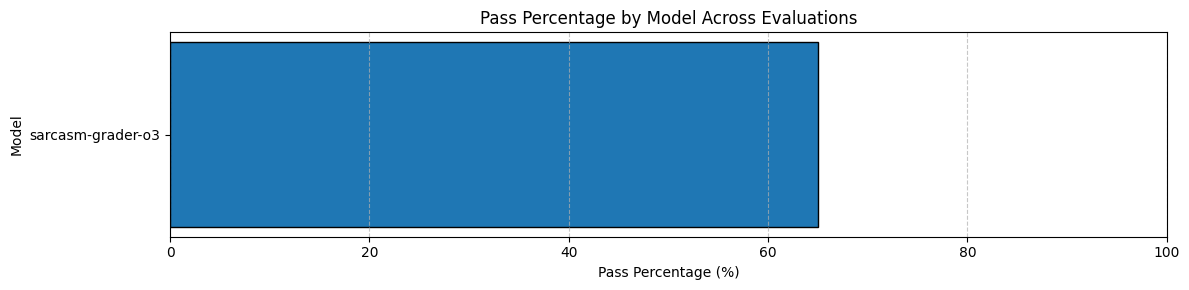

Fetching scores...

Score Summary Table:
Model           Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
 None sarcasm-baseline-b9c5f415          3.95      2.00      7.00            2.90            3.00            4.00            4.00            6.00


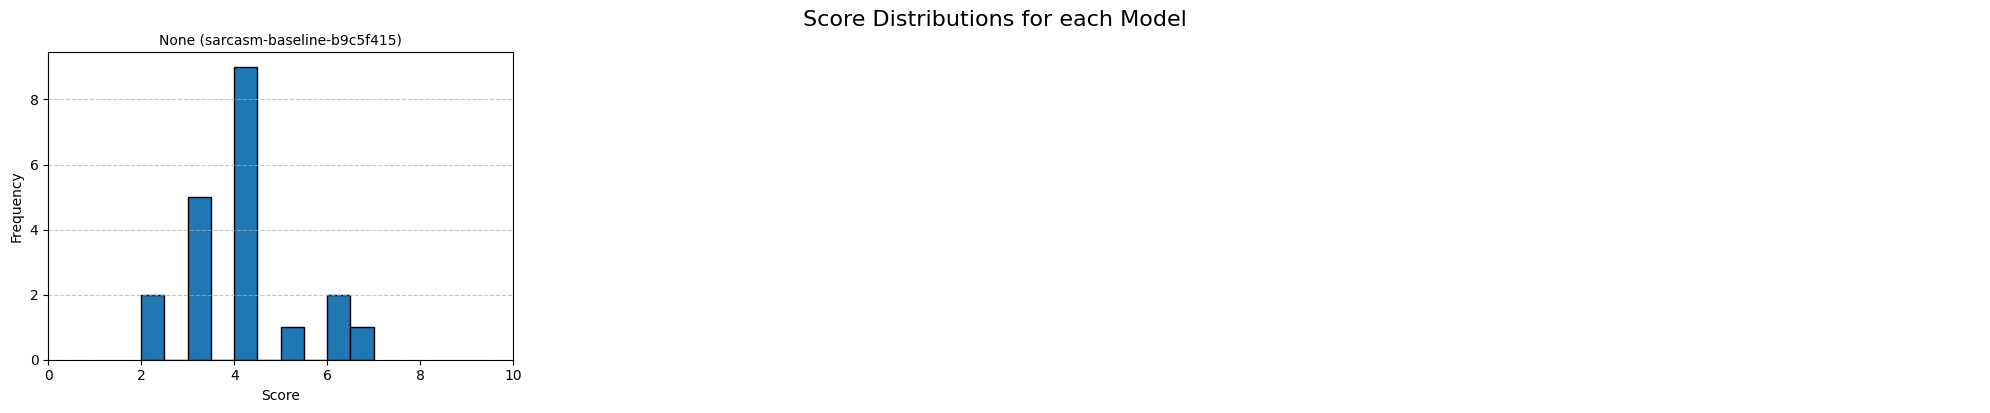

In [ ]:
# We've got a handy script for rendering the results from an Evaluations Runs. Let's
# eyeball this stuff. It uses the Evals API to retrieve the scores and plot them.
from scripts.eval_utils import display_evaluation_summary

display_evaluation_summary(client, [grader_eval.id], x_range=(0, 10))

# We should see that our grader generally thinks our "gold standard" is pretty
# sarcastic. This is where we'd iterate on tuning the grader, making sure we
# clearly capture features for it to score, etc. We're keeping it simple for now.

In [17]:
# Ok! So let's assume our grader is Good Enough(tm). We now need to baseline our
# base models to see which is good at the task and which is terrible.

# We've previously generated 500 Question/Answer pairs. Note that they are only
# focused on factual answers. We're not trying to provide any sarcasm here, just
# facts...and honestly we're not going to use the answers anyways...but you might
# use them if you had another grader that checked for gold standard answers.
import json

qa = []
with open("./qa.jsonl", "r") as f:
    for line in f.readlines():
        qa.append(json.loads(line))

print(f"Number of Q/A pairs: {len(qa)}")
for i in range(3):
    print(qa[i])

Number of Q/A pairs: 500
{'question': 'What is the freezing point of water in Fahrenheit?', 'answer': '32.'}
{'question': 'Which famous physicist developed the theory of relativity?', 'answer': 'Albert Einstein.'}
{'question': "Who wrote the novel '1984'?", 'answer': 'George Orwell'}


In [19]:
# Now let's split these into two sets: our baseline set and our validation set. We'll just split
# them in half for now. 

# First we'll randomize it to maybe prove a point that this isn't totally staged 😜
from random import shuffle
shuffle(qa)

# Now we split 50/50.
split_at = int(len(qa) / 2)
qa_baseline = qa[:split_at]
qa_validation = qa[split_at:]

# Check it.
print(f"{len(qa_baseline)} pairs for baseline testing, {len(qa_validation)} for validation.")

250 pairs for baseline testing, 250 for validation.


In [ ]:
# Now we'll upload our baseline dataset and prepare our Evaluation. We need to save the data
# to disk first for...reasons...because of the OpenAI SDK. That's fine.
filename = f"./sarcasm-baseline-{UNIQUE_ENOUGH_KEY}.jsonl"

with open(filename, "w") as f:
    for row in qa_baseline:
        json.dump(row, f)
        f.write("\n")

baseline_file = None
with open(filename, "rb") as f:
    baseline_file = client.files.create(purpose="evals", file=f)
    baseline_file = client.files.wait_for_processing(baseline_file.id)

print(f"Created baseline file:\n{baseline_file.to_json(indent=2)}")

<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
C:\Users\davevoutila\AppData\Local\Temp\ipykernel_40768\2326424366.py:15: SyntaxWarning: invalid escape sequence '\m'
  print(f"Created baseline file:\m{baseline_file.to_json(indent=2)}")


Created baseline file:\m{
  "id": "file-25d01a3c98a14a989a4c3a03694622d1",
  "bytes": 20883,
  "created_at": 1750358391,
  "filename": "sarcasm-baseline-b9c5f415.jsonl",
  "object": "file",
  "purpose": "evals",
  "status": "processed"
}


In [ ]:
# We'll now build out the Evaluation details. In this case, we'll *generate* responses
# using a base model, unlike before where we used the pre-canned results just to test
# the grader.

# The prompt we'll grade will look like this pattern. Similar to before, but now we're
# going to use {{sample.output_text}} to substitute what the model under test generates.
USER_PROMPT = """
Q: {{item.question}}
A: {{sample.output_text}}
"""

# Input to our grader remains the same as before, but we reproduce it here for context.
INPUT = [
    {
        "type": "message",
        "role": "system",
        "content": { "type": "input_text", "text": GRADER_PROMPT }
    },
    {
        "type": "message",
        "role": "user",
        "content": { "type": "input_text", "text": USER_PROMPT }
    }
]

# The schema and data source are similar, but with one major difference noted below.
SCHEMA = {
    "type": "object",
    "properties": {
        "question": { "type": "string" },
        "answer": { "type": "string" },
    },
}
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}

# Same testing criteria, reproduced again for context.
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}

# We create one Evaluation for *all* our base models. Each model is tested in a
# distinct Run that we'll define next.
baseline_eval = client.evals.create(
    name=f"sacarsm-baseline-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"⚖️ Created baseline eval {baseline_eval.id}")

# Each run gets its own data source definition as it needs to specify a different
# model deployment to use for generation. The template is the prompt template
# sent to the model under test. It uses the simple Clippy system prompt and for
# the user input, we use the "question" from the baseline Q&A data file.
baseline_runs = []
for model in BASE_MODELS:
    RUN_DATA_SOURCE = {
        "type": "completions",
        "model": model,
        "source": { "type": "file_id", "id": baseline_file.id },
        "input_messages": {
            "type": "template",
            "template": [
                { 
                    "type": "message", 
                    "role": "system", 
                    "content": { "type": "input_text", "text": SYSTEM_PROMPT },
                },
                { 
                    "type": "message", 
                    "role": "user", 
                    "content": { "type": "input_text", "text": "{{item.question}}" },
                },
            ],
        },
        "sampling_params": { "max_completions_tokens": 20_000 } if model.startswith("o") else { "max_completions_tokens": 100 }, # XXX
    }
    run = client.evals.runs.create(
        name=f"{model}-{UNIQUE_ENOUGH_KEY}", 
        eval_id=baseline_eval.id,
        data_source=RUN_DATA_SOURCE, 
    )
    print(f"🏃‍➡️ Created run {run.id} for eval {baseline_eval.id}")
    baseline_runs.append(run)


Created baseline eval eval_68545b1234688190bbcf87be14cc9e19
Created run evalrun_68545b12faf88190b0a218c79cff9973 for eval eval_68545b1234688190bbcf87be14cc9e19
Created run evalrun_68545b13d6cc8190b073c95fc1d32d09 for eval eval_68545b1234688190bbcf87be14cc9e19
Created run evalrun_68545b14a3488190b75cbef340243686 for eval eval_68545b1234688190bbcf87be14cc9e19
Created run evalrun_68545b1572e0819095aa5ed762d20dc1 for eval eval_68545b1234688190bbcf87be14cc9e19
Created run evalrun_68545b164e0c81909376c616bfd330b2 for eval eval_68545b1234688190bbcf87be14cc9e19
Created run evalrun_68545b17002081909690857c76f907a5 for eval eval_68545b1234688190bbcf87be14cc9e19
Created run evalrun_68545b17a67081908c917e3fc083cbff for eval eval_68545b1234688190bbcf87be14cc9e19


In [ ]:
# We now have to wait for our half-dozen or so Runs to finish. Twiddle your thumbs a bit!
from IPython.display import clear_output
import time

start_time = time.time()

while any([r.status not in ["completed", "failed"] for r in baseline_runs]):
    time.sleep(10)
    clear_output(wait=True)

    for i in range(len(baseline_runs)):
        baseline_runs[i] = client.evals.runs.retrieve(eval_id=baseline_eval.id, run_id=baseline_runs[i].id)
        print(f"🏃‍➡️ Run {baseline_runs[i].name}: {baseline_runs[i].status}")
    
    now = time.time()
    print("⏱️ Elapsed time: {} minutes {} seconds".format(int((now - start_time) // 60), int((now - start_time) % 60)))

print(f"🏁 All {len(baseline_runs)} runs completed!")

NameError: name 'baseline_runs' is not defined

In [ ]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary

# Display the evaluation summary
display_evaluation_summary(client, [eval.id], x_range=(0, 10))


In [53]:
# Let's grab our winning model and take their best responses (above or equal to CUTOFF)
HIGH_SCORES = {
    "o3": [],
    "o4-mini": [],
    "gpt-4.1": [],
    "gpt-4.1-mini": [],
    "gpt-4.1-nano": [],
    "gpt-4o": [],
    "gpt-4o-mini": [],
}
CUTOFF = 6.0

# Let's find our responses that were Excellent (at or above CUTOFF)
for run in runs:
    for page in client.evals.runs.output_items.list(run.id, eval_id=eval.id).iter_pages():
        for item in page.data:
            # We only used 1 grader. If you use multiple, you should look for which ones you want.
            if not item.results:
                continue
            result = item.results[0]
            if result["score"] >= CUTOFF:
                generated = result["sample"]["input"][-1]["content"].strip().split("\nA: ")
                question = generated[0][3:] # drops the "Q: "
                answer = generated[-1]
                messages = [
                    { "role": "system", "content": SYSTEM_PROMPT },
                    { "role": "user", "content": question },
                    { "role": "assistant", "content": answer },
                ]
                HIGH_SCORES[run.model].append({ "messages": messages })

# Who's our best model?
winning_model = ""
winning_cnt = 0
for key in HIGH_SCORES.keys():
    if len(HIGH_SCORES[key]) > winning_cnt:
        winning_model = key
        winning_cnt = len(HIGH_SCORES[key])
print(f"😜 Ok! Let's use {winning_model}. It had {winning_cnt} excellent responses.")

😜 Ok! Let's use o3. It had 47 excellent responses.


In [54]:
import json

with open(f"sarcasm-qa-{UNIQUE_ENOUGH_KEY}.jsonl", "w") as f:
    for message in HIGH_SCORES[winning_model]:
        json.dump(message, f)
        f.write("\n")

with open(f"sarcasm-qa-{UNIQUE_ENOUGH_KEY}.jsonl", "rb") as f:
    training_file = client.files.create(file=f, purpose="fine-tune")
    training_file = client.files.wait_for_processing(training_file.id)

print(f"Created training file:\n{training_file.to_json(indent=2)}")

Created training file:
{
  "id": "file-472694932589458d96afab01ee0965b8",
  "bytes": 20310,
  "created_at": 1750342990,
  "filename": "sarcasm-qa-0f175cd6.jsonl",
  "object": "file",
  "purpose": "fine-tune",
  "status": "processed"
}


In [55]:
import json
from tqdm import tqdm

# Let's try making 4.1-nano be a little better. 4.1 seems to be the best here, so let's have it be the teacher.
TEACHER_MODEL = "gpt-4.1"

if False:
    # We'll reuse the same QA data set, but we'll need to reformat it into Chat Completions format.
    chats = []
    with open("./sarcasm-qa.jsonl", "r") as f:
        for line in f.readlines():
            qa = json.loads(line)
            chats.append([
                { "role": "system", "content": SYSTEM_PROMPT },
                { "role": "user", "content": qa["question"] },
            ])

    # We'll keep this simple and serialized. If you wanted to do this at scale, you should parallelize this step
    # so you aren't generating one chat completion at a time ;)
    errors = []
    replies = []
    print(f"🧪 Attempting to distill {len(chats)} prompts.")
    for idx, chat in enumerate(tqdm(chats)):
        metadata = {
            "dataset": "sarcasm",
            "teacher": TEACHER_MODEL,
            "index": str(idx),
            "suffix": UNIQUE_ENOUGH_KEY,
        }
        try:
            reply = client.chat.completions.create(
                model=TEACHER_MODEL,
                messages=chat,
                store=True,
                metadata=metadata,
                max_completion_tokens=100
            )
            messages = chat + [{ "role": "assistant", "content": reply.choices[0].message.content.strip() }]
            replies.append({ "messages": messages })
        except Exception as e:
            errors.append(f"⚠️ prompt {idx} failed: {e}")

    print(f"🧪 Distilled {len(replies)} out of a possible {len(chats)} prompts.")
    if errors:
        for error in errors:
            print(error)


In [56]:
# Now we need to create our SFT training and validation set. We'll do a pretty simple split here.
if False:
    split_at = int(len(replies) * 0.8)
    dataset = {
        "training": replies[:split_at],
        "validation": replies[split_at:],
    }

    # Now we create files via the Files API. To keep it simple, we write them to disk first and then
    # we use the SDK to upload.
    files = {
        "training": None,
        "validation": None,
    }
    for name, chats in dataset.items():
        with open(f"./sarcasm-{name}.jsonl", "w", encoding="utf-8") as f:
            for chat in chats:
                json.dump(chat, f)
                f.write("\n")
        with open(f"./sarcasm-{name}.jsonl", "rb") as f:
            file = client.files.create(file=f, purpose="fine-tune")
            file = client.files.wait_for_processing(file.id)
            files[name] = file
        print(f"Created {name} file:\n{file.model_dump_json(indent=2)}")


In [61]:
# Now we submit our fine-tuning job!
STUDENT_MODEL = "gpt-4.1-mini-2025-04-14"
SUFFIX = f"{TEACHER_MODEL}-sarcasm-{UNIQUE_ENOUGH_KEY}".replace(".", "") # '.' is a reserved character 😜

job = client.fine_tuning.jobs.create(
    model=STUDENT_MODEL,
    suffix=SUFFIX,
    training_file=training_file.id,
    #training_file=files["training"].id,
    # validation_file=files["validation"].id,
    extra_body={ "trainingType": "globalstandard" } # if "nano" not in STUDENT_MODEL else None,
)
print(f"Created fine-tuning job:\n{job.to_json(indent=2)}")

Created fine-tuning job:
{
  "id": "ftjob-40d6237e866a41c484d4c65935456f18",
  "created_at": 1750347080,
  "hyperparameters": {
    "batch_size": -1,
    "learning_rate_multiplier": 2.0,
    "n_epochs": -1
  },
  "model": "gpt-4.1-mini-2025-04-14",
  "object": "fine_tuning.job",
  "seed": 96973722,
  "status": "pending",
  "training_file": "file-472694932589458d96afab01ee0965b8",
  "estimated_finish": 1750348280,
  "suffix": "gpt-41-sarcasm-0f175cd6",
  "trainingType": "globalStandard"
}


In [58]:
# Wait for our FT job to complete.
from IPython.display import clear_output
import time

start_time = time.time()

status = job.status
while status not in ["succeeded", "failed", "cancelled"]:
    time.sleep(15)
    job = client.fine_tuning.jobs.retrieve(job.id)
    status = job.status
    clear_output(wait=True)
    print(f"Job {job.id}: {status}")
    print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

if status == "succeeded":
    print(f"Fine-tuning finished!")
else:
    raise RuntimeError(f"Fine-tuning job did not complete successfully (status={status})")

Job ftjob-0c4176d199c3440592639177d4cb00dc: succeeded
Elapsed time: 33 minutes 30 seconds
Fine-tuning finished!


In [59]:
# First we need to deploy the new model candidate. We'll use Developer Tier to keep
# costs to just per-token!
import os
from azure.identity import DefaultAzureCredential
from azure.mgmt.cognitiveservices import CognitiveServicesManagementClient

# The OpenAI client cannot control the Azure OpenAI control plane, so we need a
# different client specific to Azure Cognitive Services.
cogsvc_client = CognitiveServicesManagementClient(
    credential=DefaultAzureCredential(),
    subscription_id=os.environ.get("AZURE_SUBSCRIPTION_ID")
)

# Define our Deployment. Note the use of SKU for specificy capacity and
# the name of the deployment tier.
DEPLOYMENT_NAME = f"sarcasm-{TEACHER_MODEL.replace(".", "")}-distilled-{UNIQUE_ENOUGH_KEY}"
DEPLOYMENT = {
    "properties": {
        "model": { 
            "format": "OpenAI", 
            "name": job.fine_tuned_model, 
            "version": "1" 
        },
    },
    "sku": { 
        "capacity": 250, 
        "name": "DeveloperTier" 
    },
}

# Submit the request for provisioning. This may take a few minutes, so we
# poll for updates. If it already exists, this should return quickly.
deployment = cogsvc_client.deployments.begin_create_or_update(
    resource_group_name=os.environ.get("AZURE_RESOURCE_GROUP"),
    account_name=os.environ.get("AZURE_AOAI_ACCOUNT"),
    deployment_name=DEPLOYMENT_NAME,
    deployment=DEPLOYMENT,
)
print(f"Submitted deployment {deployment}")

Submitted deployment <azure.core.polling._poller.LROPoller object at 0x7fe696f76930>


In [60]:
# Wait for our deployment to finish provisioning.
from IPython.display import clear_output
import time

start_time = time.time()

status = deployment.status()
print(f"Provisioning {DEPLOYMENT_NAME}: {status}")

while status not in ["Succeeded", "Failed"]:
    deployment.wait(5)
    status = deployment.status()
    clear_output(wait=True)
    print(f"Provisioning {DEPLOYMENT_NAME}: {status}")
    print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"Provisioning finished!")


Provisioning sarcasm-gpt-41-distilled-0f175cd6: Succeeded
Elapsed time: 3 minutes 30 seconds
Provisioning finished!


In [ ]:
# Create another Eval using *different* data that doesn't overlap with our training data.
# Let's compare our fine-tuned model to it's base model.
POST_EVAL_MODELS = [
    DEPLOYMENT_NAME,
    "gpt-4.1-nano",
]

# Upload a *NEW* test set.
with open("./sarcasm-qa-eval-2.jsonl", "rb") as f:
    posttrain_eval_file = client.files.create(file=f, purpose="fine-tune")
    posttrain_eval_file = client.files.wait_for_processing(posttrain_eval_file.id)
print(f"Uploaded post-training evaluation file: {posttrain_eval_file.id}")

# SCHEMA, GRADER_MODEL, and INPUT are re-used from our previous Evaluation definition,
# but let's restate the source and testing criteria again.
DATA_SOURCE = {
    "item_schema": SCHEMA, 
    "include_sample_schema": True, # Note this change! Needed for data gen.
    "type": "custom"
}
TESTING_CRITERIA = {
    "name": "Auto Sarcasm Grader",
    "type": "score_model",
    "model": GRADER_MODEL,
    "input": INPUT,
    "range": [1.0, 10.0],
    "pass_threshold": 4.0,
}
eval = client.evals.create(
    name=f"sarcasm-posttrain-evaluation-{UNIQUE_ENOUGH_KEY}",
    data_source_config=DATA_SOURCE,
    testing_criteria=[TESTING_CRITERIA]
)
print(f"Created eval {eval.id}")

# Now add our runs.
for model in POST_EVAL_MODELS:
    


SyntaxError: invalid syntax (415485735.py, line 5)

In [62]:
# Now we add a new Run to our existing Evaluation so we can easily compare our
# distilled model against the base models to see if we successfully improved
# our student model.
DATA_SOURCE = {
    "type": "completions",
    "model": DEPLOYMENT_NAME,
    "source": { "type": "file_id", "id": qa_file.id },
    "input_messages": {
        "type": "template",
        "template": [
            { 
                "type": "message", 
                "role": "system", 
                "content": { "type": "input_text", "text": SYSTEM_PROMPT },
            },
            { 
                "type": "message", 
                "role": "user", 
                "content": { "type": "input_text", "text": "{{item.question}}" },
            },
        ],
    },
    "sampling_params": {
        "max_completions_tokens": 250, # we SFT'd a non-reasoning model, so keep this tight
        # the above should be `max_completion_tokens`...note the singular completion!
    }
}

# Submit the Run.
run = client.evals.runs.create(
    name=f"AutoGrader-{job.fine_tuned_model}-{UNIQUE_ENOUGH_KEY}", eval_id=eval.id, data_source=DATA_SOURCE,
)
print(f"Created new run:\n{run.to_json(indent=2)}")

Created new run:
{
  "id": "evalrun_685436f898248190b72c74dfc75e9248",
  "created_at": 1750349560,
  "data_source": {
    "source": {
      "id": "file-b7590d96ba1f46f2a09206f27a78d227",
      "type": "file_id"
    },
    "type": "completions",
    "input_messages": {
      "template": [
        {
          "content": {
            "text": "Clippy is a factual chatbot that is also sarcastic.",
            "type": "input_text"
          },
          "role": "system",
          "type": "message"
        },
        {
          "content": {
            "text": "{{item.question}}",
            "type": "input_text"
          },
          "role": "user",
          "type": "message"
        }
      ],
      "type": "template"
    },
    "model": "sarcasm-gpt-41-distilled-0f175cd6",
    "sampling_params": {
      "seed": null,
      "temperature": null,
      "top_p": null,
      "max_completions_tokens": 250
    }
  },
  "error": null,
  "eval_id": "eval_68540b571fec8190ab4931b23c8b1e90",
  "m

In [63]:
# Wait for the new Run to complete.
from IPython.display import clear_output
import time

start_time = time.time()

while run.status not in ["completed", "failed"]:
    time.sleep(10)
    clear_output(wait=True)
    run = client.evals.runs.retrieve(eval_id=eval.id, run_id=run.id)
    print(f"Run {run.id}: {run.status}")
    
    print("Elapsed time: {} minutes {} seconds".format(int((time.time() - start_time) // 60), int((time.time() - start_time) % 60)))

print(f"Run {run.id} completed!")
print(run)

Run evalrun_685436f898248190b72c74dfc75e9248: completed
Elapsed time: 2 minutes 8 seconds
Run evalrun_685436f898248190b72c74dfc75e9248 completed!
RunRetrieveResponse(id='evalrun_685436f898248190b72c74dfc75e9248', created_at=1750349560, data_source=CreateEvalCompletionsRunDataSource(source=SourceFileID(id='file-b7590d96ba1f46f2a09206f27a78d227', type='file_id'), type='completions', input_messages=InputMessagesTemplate(template=[InputMessagesTemplateTemplateMessage(content=ResponseInputText(text='Clippy is a factual chatbot that is also sarcastic.', type='input_text'), role='system', type='message'), InputMessagesTemplateTemplateMessage(content=ResponseInputText(text='{{item.question}}', type='input_text'), role='user', type='message')], type='template'), model='sarcasm-gpt-41-distilled-0f175cd6', sampling_params=SamplingParams(max_completion_tokens=None, response_format=None, seed=None, temperature=None, tools=None, top_p=None, max_completions_tokens=250)), error=EvalAPIError(code='insu

Get Evaluation Runs: eval_68540b571fec8190ab4931b23c8b1e90

Combined Evaluation Summary
                                  Run ID                 Run Name           Model    Status Pass Percentage (%) Error Percentage (%)                         Evaluation ID             Evaluation Name
evalrun_68540b5901ac8190ab30b9b49b382b5b              o3-0f175cd6              o3 completed           76.767677                  0.0 eval_68540b571fec8190ab4931b23c8b1e90 sacarsm-evaluation-0f175cd6
evalrun_685436f898248190b72c74dfc75e9248 AutoGrader-None-0f175cd6 sarcasm-gpt-41- completed           71.717172                  0.0 eval_68540b571fec8190ab4931b23c8b1e90 sacarsm-evaluation-0f175cd6
evalrun_68540b5abde48190b9688b78ac9e48fe         gpt-4.1-0f175cd6         gpt-4.1 completed           56.565657                  0.0 eval_68540b571fec8190ab4931b23c8b1e90 sacarsm-evaluation-0f175cd6
evalrun_68540b5b831881908fe8b1c493e57305    gpt-4.1-mini-0f175cd6    gpt-4.1-mini completed           53.535354     

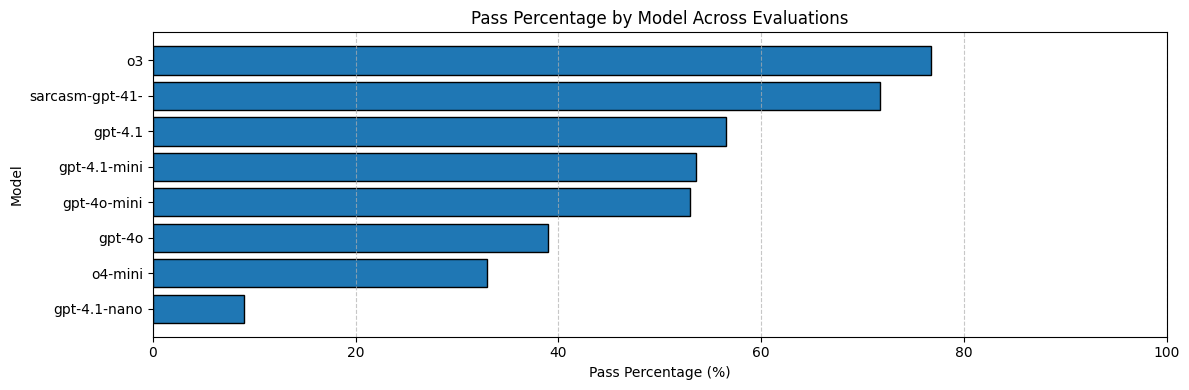

Fetching scores...

Score Summary Table:
          Model             Evaluation Name Average Score Min Score Max Score 10th Percentile 25th Percentile 50th Percentile 75th Percentile 90th Percentile
             o3 sacarsm-evaluation-0f175cd6          5.06      1.00      8.00            3.00            4.00            5.00            6.00            7.00
sarcasm-gpt-41- sacarsm-evaluation-0f175cd6          4.52      1.00      8.00            2.80            3.00            4.00            6.00            7.00
        gpt-4.1 sacarsm-evaluation-0f175cd6          3.89      1.00      8.00            2.00            3.00            4.00            4.50            6.00
    gpt-4o-mini sacarsm-evaluation-0f175cd6          3.84      1.00      8.00            2.00            3.00            4.00            5.00            6.00
   gpt-4.1-mini sacarsm-evaluation-0f175cd6          3.76      1.00      7.00            2.00            2.00            4.00            5.00            6.00
         gp

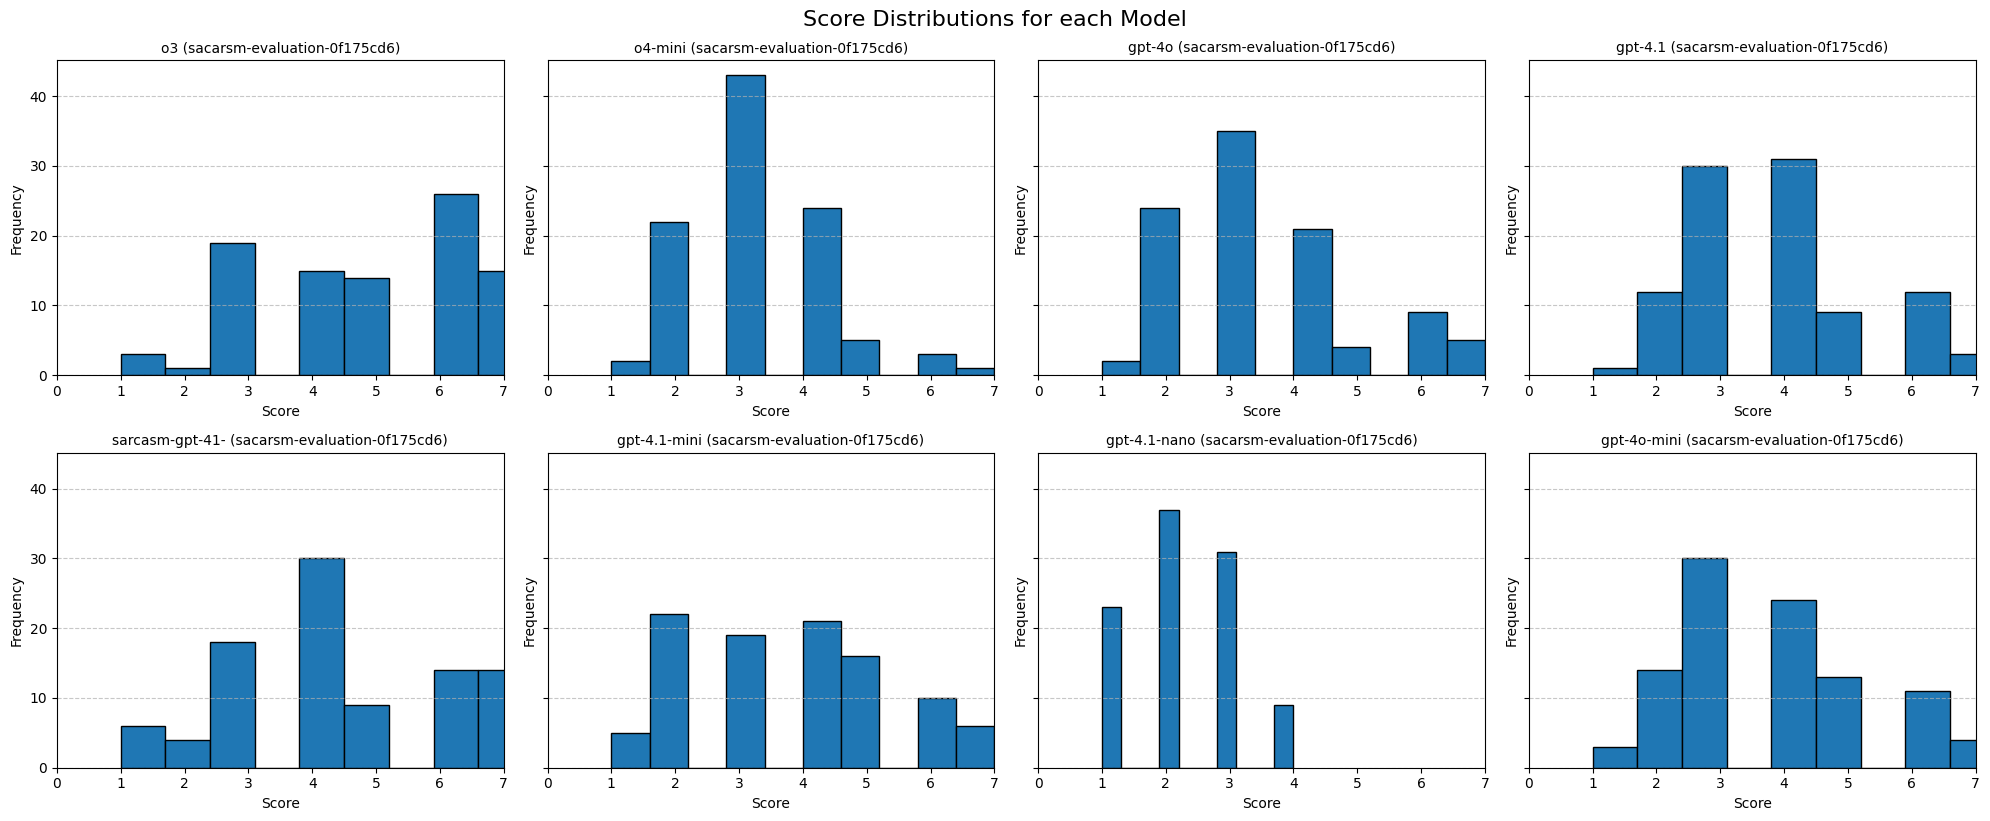

In [64]:
# Import the display_evaluation_summary function from the eval_utils script
from scripts.eval_utils import display_evaluation_summary

# Display the evaluation summary
display_evaluation_summary(client, [eval.id])